In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
from collections import Counter
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv('hr.csv')

/Users/yang/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (48,52,55,56,57,59,60,61,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Cleaning & Feature Engineering

### remove redundant columns and perform type conversion, encoding etc.

In [3]:
text_cols = ['EDUCATION_LEVEL','COUNTRY_OF_CITIZENSHIP','HOME_CITY','VISA','JOB_GRADE','JOB_TITLE','Manager_Edu_Level'\
             ,'EDUCATION_LEVEL_YEAR','Manager_Edu_Level_Year','REPORTS_TO_PENN_ID']
for col in text_cols:
    data[col] = data[col].fillna('')
    data[col] = data[col].apply(str).str.strip()
    
edu_cols = ['EDUCATION_LEVEL_YEAR','Manager_Edu_Level_Year']
for col in edu_cols:
    data[col] = data[col].apply(lambda x: int(x) if len(x)>0 else None)

In [4]:
# transform str to datetime object
dates_cols = ['Birth_Date','PRIMARY_APPT_BEGIN_DATE','ORIGINAL_HIRE_DATE','TERMINATION_DATE']
for col in dates_cols:
    data[col] = pd.DatetimeIndex(data[col])

#### Make new age columns
Age/Time related columns
'Birth_Date', 'AGE_AT_TERMINATION', 'CURRENT_AGE', 'PRIMARY_APPT_BEGIN_DATE', 'MONTHS_IN_PRIMARY_JOB', 
'ORIGINAL_HIRE_DATE', 'TERMINATION_DATE'<br>

1.Age_start: age when started to work at Penn: ORIGINAL_HIRE_DATE - Birth_Date <br>
2.Age_last: AGE_AT_TERMINATION or CURRENT_AGE if active <br>
3.MONTHS_IN_PRIMARY_JOB<br>

Remove other Age/Time related columns other than the three above. <br>

In [5]:
data['Age_start'] = data['ORIGINAL_HIRE_DATE'] - data['Birth_Date']
data['Age_start'] = data['Age_start'].apply(lambda x: int(np.floor(x.days/365)))
data['Age_last'] = data['AGE_AT_TERMINATION'].fillna(data['CURRENT_AGE'])

#### Is_First

In [6]:
# 1 indicates the primary job is the employee's first job at Penn, 0 indicates otherwise
data['Is_First'] = (data['ORIGINAL_HIRE_DATE'] == data['PRIMARY_APPT_BEGIN_DATE']).astype(int)

data = data.drop(columns = ['Birth_Date', 'AGE_AT_TERMINATION', 'CURRENT_AGE', 'PRIMARY_APPT_BEGIN_DATE',\
                            'ORIGINAL_HIRE_DATE', 'TERMINATION_DATE'])

### Local, US

In [7]:
# replace "PHILA" with PHILADELPHIA. 
data['HOME_CITY'] = data['HOME_CITY'].apply(lambda x: 'PHILADELPHIA' if x == 'PHILA' else x)
data['Local'] = data['HOME_CITY'].apply(lambda x: 1 if x == 'PHILADELPHIA' else 0)
data['US'] = data['COUNTRY_OF_CITIZENSHIP'].apply(lambda x: 1 if x == '' else 0)

data = data.drop(columns = ['COUNTRY_OF_CITIZENSHIP','HOME_CITY'])

### average ratings

In [8]:
rating_map = {'E':10,'R':8,'M':6,'N':4,'U':2}
rating_df = pd.DataFrame()
for year in range(2010,2020):
    data['OVR_RATING_CD_'+str(year)] = data['OVR_RATING_CD_'+str(year)].apply(lambda x: rating_map[x] if x in rating_map else 0)
    rating_df = pd.concat([rating_df,data['OVR_RATING_CD_'+str(year)]],axis=1)
    data = data.drop(columns = ['OVR_RATING_DESCR_'+str(year),'OVR_RATING_CD_'+str(year)])

valid_years = np.array([10-c[0] for c in [Counter(x) for x in rating_df.values]])
total = np.array(rating_df.apply(np.sum,axis=1).values)
avg_rating = np.zeros(len(total))
for i in range(len(total)):
    if valid_years[i] == 0:
        avg_rating[i] = None
    else:
        avg_rating[i] = total[i]/valid_years[i]
data['avg_rating'] = pd.Series(avg_rating)

### model manager data as the difference between manager and employee

### encoding the following text columns into numerical values

In [9]:
# Has_Manager indicates if a person has a manager (1)
data['Has_Manager'] = data['REPORTS_TO_PENN_ID'].apply(lambda x: 0 if len(x)==0 else 1)

# 1 if manager and employee are of different sex
data['sex_diff'] = (data["SEX"]!=data['Manager_Sex']).apply(int)
data.loc[data['Manager_Sex'].isnull(),'sex_diff'] = 0

# 1 if manager and employee are of different race
data['race_diff'] = (data["RACE"]!=data['Manager_Race']).apply(int)
data.loc[data['Manager_Race'].isnull(),'race_diff'] = 0

data = data.drop(columns = ['Manager_Race','Manager_Sex'])

#### Education level 

In [10]:
edu_map = {'B':0, 'C':1,'E':2, 'D':2, 'F':3, 'G':4, 'H':5, 'K':6,'I':6, 'L':6, 'J':6}

# map NaN in education level to 1, same group as "C"
data['EDUCATION_LEVEL'] = data['EDUCATION_LEVEL'].apply(lambda x: edu_map[x] if x in edu_map else 1)

# leave NaN in nanager education as None
data['Manager_Edu_Level'] = data['Manager_Edu_Level'].apply(lambda x: edu_map[x] if x in edu_map else None)

# difference between manager and employee education levels
# if someone doesn't have a manager, or manager education data is missing make the difference 0
data['edu_diff'] = data['Manager_Edu_Level'] - data['EDUCATION_LEVEL']
data['edu_diff'] = data['edu_diff'].fillna(0)

# remove EDUCATION_LEVEL_YEAR for now, 5000 missing values
data = data.drop(columns=['EDUCATION_LEVEL_YEAR','Manager_Edu_Level'])

In [11]:
data['PAY_CYCLE'] = data['PAY_CYCLE'].apply(lambda x: 0 if x == 'M1' else 1)
data['SEX'] = data['SEX'].apply(lambda x: 0 if x == 'M' else 1)

categorical_cols = ['RACE','MARITAL_STATUS','GRANT_PAID']
for col in categorical_cols:
    df = pd.get_dummies(data[col]).rename(lambda x: col+'_'+str(x), axis=1)
    data = pd.concat([data, df], axis=1)
    data = data.drop(columns = col)

#### job grade

Remove job grade = 'PHR'<br>
Job grade A-H are IT positions and correspond to job grade 25-32 respectively <br>
Job grade U indicates in union: mostly maintenance people judging from their job titles, classify them as job grade 21(lowest in dataset) <br>
Add new column IS_IT <br>  


In [12]:
job_grade = {}

# create a dict that maps A-H to 25-32
for i,j in enumerate(range(25,33)):
    job_grade[chr(ord('A')+i)] = j
    
# new one-hot encoding columns IS_IT_0, IS_IT_1, 1 for yes, 0 for no
x = data['JOB_GRADE'].apply(lambda x: 1 if x in job_grade else 0)
df = pd.get_dummies(x).rename(lambda x: 'IS_IT_'+str(x), axis=1)
data = pd.concat([data, df], axis=1)

# convert letter job grades to numbers
job_grade['U'] = 21
data['JOB_GRADE'] = data['JOB_GRADE'].apply(lambda x: job_grade[x] if x in job_grade else x)

# Remove job grade = 'PHR'
data = data[data['JOB_GRADE']!='PHR']

data['JOB_GRADE'] = data['JOB_GRADE'].astype(int)

In [13]:
redundant_cols = ['Race_Desc','Sex_Desc','EDUCATION_LEVEL_DESC','HOME_ZIP','YEARS_IN_PRIMARY_JOB','YEARS_OF_SERVICE',
                  'EMPLOYMENT_STATUS_DESC',
                  'Dept_Name','Dept_Name_Short',
                  'School_Name','School_Abbrev',
                  'PRIMARY_APPT_JOB_CLASS',
                  'Job_Grade_Fiscal_Year','AnnualMinimum',
                  'AnnualFirstThird','AnnualMidPoint','AnnualSecondThird','AnnualMax',
                  'REPORTS_TO_PENN_ID',
                  'REPORTS_TO_DATE',
                  'Manager_Years_Managed',
                  'Manager_Original_Hire_Date',
                  'Manager_Edu_Level_Desc','Manager_Sex_Desc','Manager_Race_Desc','Termination_Fiscal_Year',
                  'SEPERATION_REASON_DESC',
                  'Retirement_Eligible_Date']

data = data.drop(columns = redundant_cols)

#### remove rating and some manager data

In [14]:
data = data.drop(columns = ['Manager_Months_Managed','Manager_Current_Age','Manager_Age_At_Termination',\
                            'Manager_Edu_Level_Year','Manager_YEARS_OF_SERVICE','Manager_OfColor','Manager_Job_Title'])
data = data.drop(columns = 'avg_rating')

####  remove home department data

In [15]:
data = data.drop(columns = ['HOME_DEPT_ORG', 'HOME_SCHOOL_CTR'])

####  Remove Race_OfColor, JOB_TITLE and SEPARATION_REASON

In [16]:
# remove entries whose separation reason is death or retirement
data = data[(data['SEPARATION_REASON'] !='80') & (data['SEPARATION_REASON'] !='30') \
            &(data['SEPARATION_REASON'] !='33') & (data['SEPARATION_REASON'] !='81')]

In [17]:
data = data.drop(columns = ['Race_OfColor','JOB_TITLE', 'SEPARATION_REASON'])

#### TO DO: 
1.partition by home school ctr <br>
2.Fiscal Year is ignored here <br>
3.add column: if visa terminates within a year of terminatino date/in two years if active

In [18]:
data['VISA_EXPIRATION_DATE'] = pd.DatetimeIndex(data['VISA_EXPIRATION_DATE'])
data = data.drop(columns = ['VISA','VISA_EXPIRATION_DATE'])

In [19]:
data.head()

,Worker_ID,SEX,EDUCATION_LEVEL,MONTHS_IN_PRIMARY_JOB,PRIMARY_APPT_SALARY,JOB_GRADE,IN_UNION,PAY_CYCLE,Starting_Full_Time_Salary,Career_Salary_Growth,Percent_Career_Salary_Growth,Number_of_Sal_Adjustments,Number_of_Reclass,EMPLOYMENT_STATUS,VOLUNTARY,JOBS_ACTIVE,Age_start,Age_last,Is_First,Local,US,Has_Manager,sex_diff,race_diff,edu_diff,RACE_A,RACE_B,RACE_C,RACE_P,RACE_R,RACE_S,RACE_U,RACE_Z,MARITAL_STATUS_D,MARITAL_STATUS_M,MARITAL_STATUS_S,MARITAL_STATUS_W,GRANT_PAID_F,GRANT_PAID_N,GRANT_PAID_P,IS_IT_0,IS_IT_1
0,1,0,1,32,41615.00,25,0,1,40000.0,1615.00,0.0403,0,0,T,0.0,0,26,28.0,1,0,1,1,0,0,4.0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0
1,2,0,4,10,32714.00,25,0,0,26000.0,6714.00,0.2582,0,0,T,1.0,0,23,27.0,0,1,1,1,0,0,0.0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0
2,3,0,4,84,62636.72,26,0,0,52000.0,10636.72,0.2045,0,0,T,0.0,0,39,46.0,1,1,1,1,1,0,2.0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1
4,5,1,1,4,29120.00,24,0,0,29120.0,0.00,0.0000,0,0,T,1.0,0,21,23.0,0,1,1,1,1,0,5.0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0
5,6,0,1,26,27895.49,24,0,0,27000.0,895.49,0.0331,0,0,T,1.0,0,23,25.0,1,0,1,1,0,0,5.0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0


## Training Data Selection

##### remove rows where Starting_Full_Time_Salary is null

In [20]:
data = data[data['Starting_Full_Time_Salary'].notnull()]

### Data selection and partition criteria
1.we would like to partition people into two classes: who stayed more than T (active or terminated) and people who stayed less than T (only terminated) <br> 
2.two classes shouldn't be skewed

In [21]:
data = data[data['MONTHS_IN_PRIMARY_JOB']>=0]

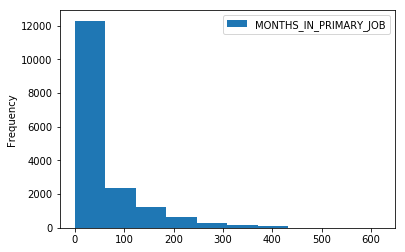

In [22]:
hist = data[['MONTHS_IN_PRIMARY_JOB']].plot.hist(bins=10)

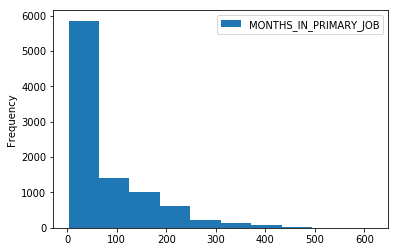

In [23]:
hist = data[['MONTHS_IN_PRIMARY_JOB']][data['EMPLOYMENT_STATUS']!='T'].plot.hist(bins=10) 

In [24]:
x = data[['MONTHS_IN_PRIMARY_JOB']][data['EMPLOYMENT_STATUS']!='T'].\
    groupby(by = np.floor(data['MONTHS_IN_PRIMARY_JOB']/12)).\
    count().rename(columns={'MONTHS_IN_PRIMARY_JOB':'count'})
display(x)

,count
MONTHS_IN_PRIMARY_JOB,
0.0,1242
1.0,1763
2.0,1197
3.0,865
4.0,584
5.0,389
6.0,352
7.0,314
8.0,295


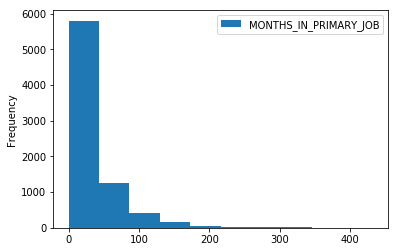

In [25]:
hist = data[['MONTHS_IN_PRIMARY_JOB']][data['EMPLOYMENT_STATUS']=='T'].plot.hist(bins=10)

In [26]:
x = data[['MONTHS_IN_PRIMARY_JOB']][data['EMPLOYMENT_STATUS']=='T'].\
    groupby(by = np.floor(data['MONTHS_IN_PRIMARY_JOB']/12)).\
    count().rename(columns={'MONTHS_IN_PRIMARY_JOB':'count'})

for c,i in enumerate(x.index):
    percentage = x.iloc[:(c+1)].values.sum()/x.values.sum()
    print('terminated within {} years (<= {} months):'.format(i+1,12*(i+1)-1), percentage , sep=' ')
    if percentage>=0.9:
        break

terminated within 1.0 years (<= 11.0 months): 0.2511621900826446
terminated within 2.0 years (<= 23.0 months): 0.506198347107438
terminated within 3.0 years (<= 35.0 months): 0.6778150826446281
terminated within 4.0 years (<= 47.0 months): 0.7762138429752066
terminated within 5.0 years (<= 59.0 months): 0.8378099173553719
terminated within 6.0 years (<= 71.0 months): 0.8762913223140496
terminated within 7.0 years (<= 83.0 months): 0.9027634297520661


#### seems like 4 years is a good place to set the threshold T

In [27]:
T = 48

In [28]:
# #high-risk
label1 = data[['Worker_ID']][(data['EMPLOYMENT_STATUS'] == 'T') & (data['VOLUNTARY'] == 1)\
                           & (data['MONTHS_IN_PRIMARY_JOB']<=T)]
#low-risk
label0 = data[['Worker_ID']][((data['VOLUNTARY'].isnull()) | (data['VOLUNTARY'] == 1))\
                           & (data['MONTHS_IN_PRIMARY_JOB']>T)]

# label0 = data[['Worker_ID']][data['EMPLOYMENT_STATUS'] == 'A']
# label1 = data[['Worker_ID']][(data['EMPLOYMENT_STATUS'] == 'T') & (data['VOLUNTARY'] == 1)]
print(label0.shape,label1.shape,data.shape,sep=' ')
data = data.drop(columns = ['EMPLOYMENT_STATUS','VOLUNTARY','MONTHS_IN_PRIMARY_JOB'])


(5642, 1) (5154, 1) (17133, 42)


In [29]:
label1['label'] = 1
label0['label'] = 0
label = pd.concat([label0,label1],axis=0)

In [30]:
data = data.merge(label, how='right')
data.set_index('Worker_ID',inplace=True)

In [31]:
data.head()

,SEX,EDUCATION_LEVEL,PRIMARY_APPT_SALARY,JOB_GRADE,IN_UNION,PAY_CYCLE,Starting_Full_Time_Salary,Career_Salary_Growth,Percent_Career_Salary_Growth,Number_of_Sal_Adjustments,Number_of_Reclass,JOBS_ACTIVE,Age_start,Age_last,Is_First,Local,US,Has_Manager,sex_diff,race_diff,edu_diff,RACE_A,RACE_B,RACE_C,RACE_P,RACE_R,RACE_S,RACE_U,RACE_Z,MARITAL_STATUS_D,MARITAL_STATUS_M,MARITAL_STATUS_S,MARITAL_STATUS_W,GRANT_PAID_F,GRANT_PAID_N,GRANT_PAID_P,IS_IT_0,IS_IT_1,label
Worker_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0,4,32714.00,25,0,0,26000.0,6714.00,0.2582,0,0,0,23,27.0,0,1,1,1,0,0,0.0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1
5,1,1,29120.00,24,0,0,29120.0,0.00,0.0000,0,0,0,21,23.0,0,1,1,1,1,0,5.0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1
6,0,1,27895.49,24,0,0,27000.0,895.49,0.0331,0,0,0,23,25.0,1,0,1,1,0,0,5.0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1
7,1,1,41593.00,26,0,0,23313.0,18280.00,0.7841,0,0,0,27,31.0,1,0,1,1,1,0,5.0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0
8,1,4,33014.00,24,0,0,31500.0,1514.00,0.0480,0,0,0,31,32.0,1,0,1,1,0,0,2.0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1


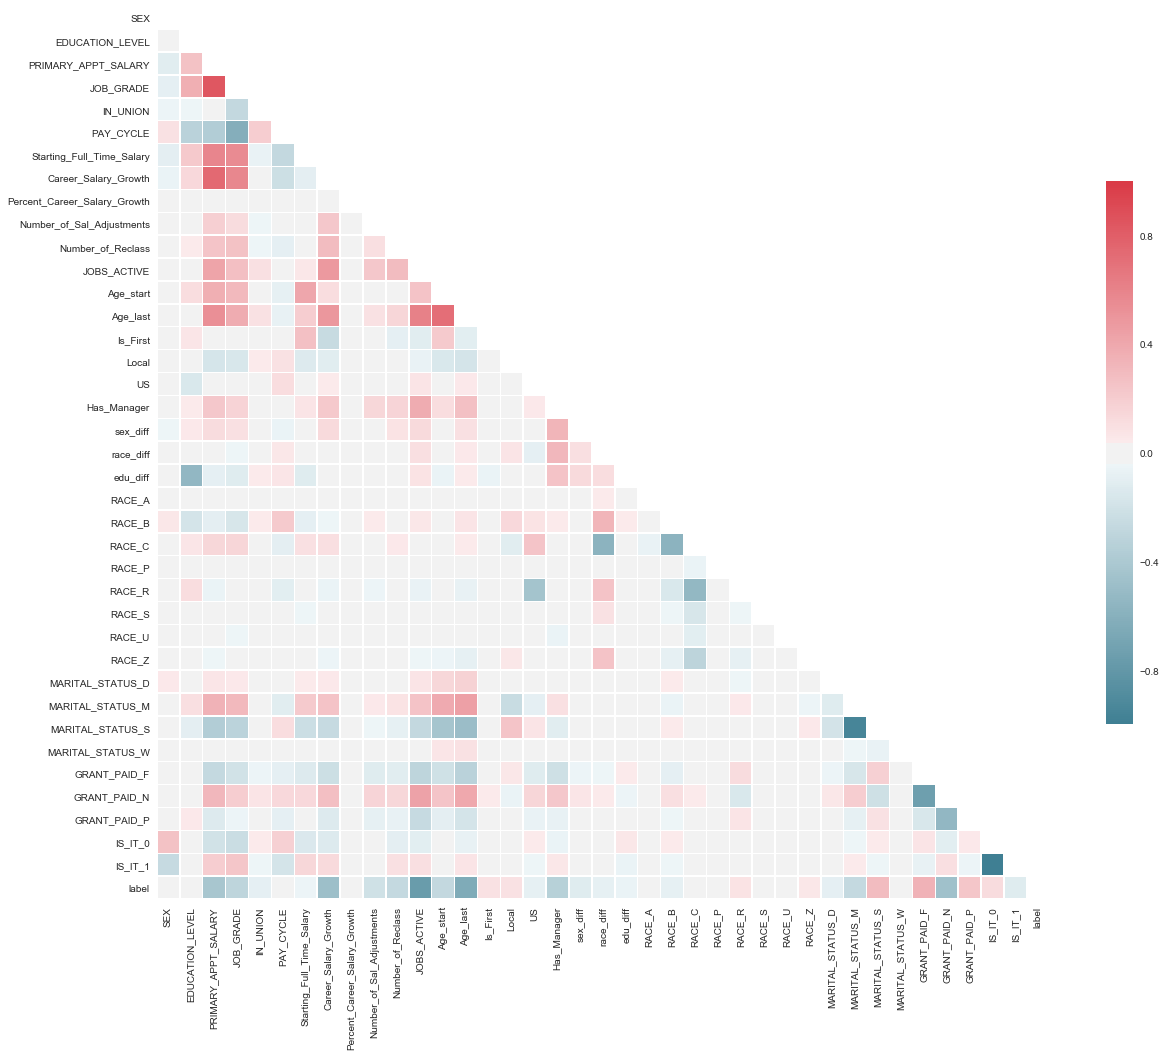

In [32]:
sns.set(style="white")

corr = data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(20,20))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

## Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data.drop(columns='label'), data[['label']], test_size=0.3)
lr = LogisticRegression().fit(x_train, y_train)
score = lr.score(x_test, y_test)
print(score)

0.8555109601728929


/Users/yang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


confusion matrix
ROC curve 
balance accuracy
f1 score
vif

In [41]:
# from sklearn import metrics
# y_true = data[['label']]
# y_pred = lr.predict(data.drop(columns='label'))
# fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
# print(fpr, tpr, thresholds)